In [1]:
import numpy as np
import math
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
# from kneed import KneeLocator
from PySide6.QtWidgets import QApplication, QVBoxLayout, QWidget
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg
from matplotlib.figure import Figure
import matplotlib.gridspec as gridspec
import cv2

from application.custom_functions import apply_circular_mask
from application.tell_time_helpers import *

In [2]:

img = cv2.imread('demo_img.png', cv2.IMREAD_GRAYSCALE)

import json
with open('demo_data.json') as f:
    lines = json.load(f)

In [3]:
labelled_dict, centers, n_clusters, inertia = cluster_lines(lines, eps=0.15)
print(centers)

[array([351.       ,   1.0035643]), array([357.5       ,   0.86393797]), array([50.        ,  2.18166161])]


dist_to_point_np, dist_to_line_np és azimuth_to_center_np függvények

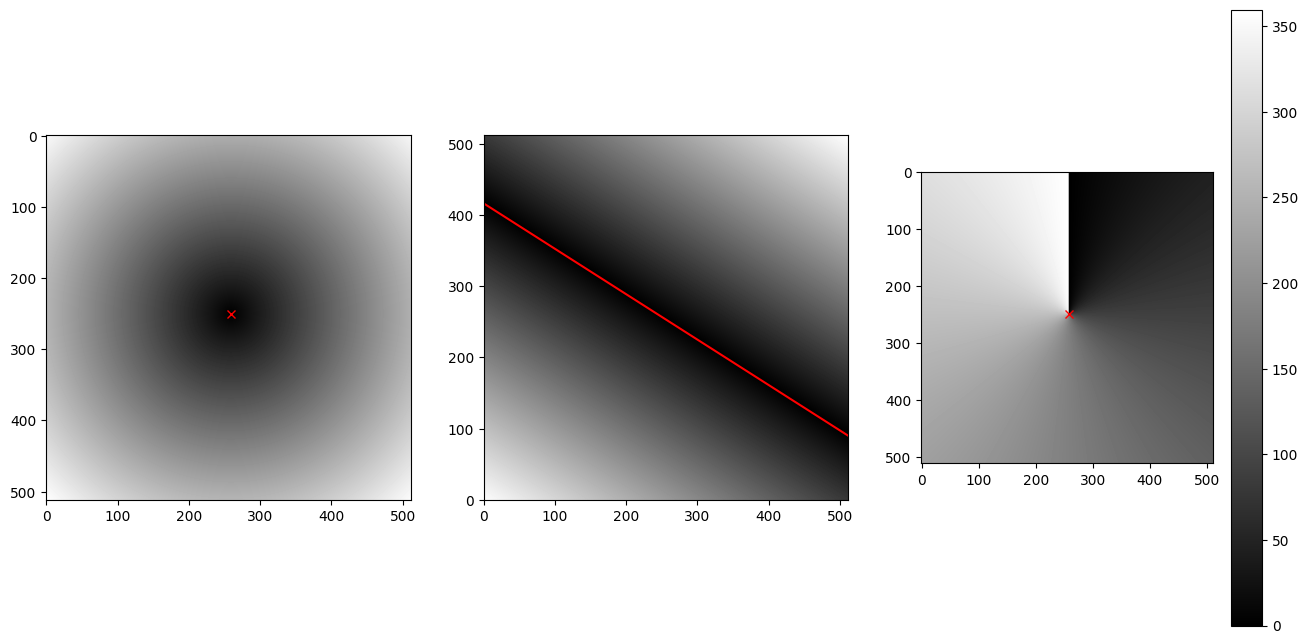

In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(16, 8))
line = centers[0]
center = find_center(img, centers)

im1 = dist_to_point_np(img, center)
im2 = dist_to_line_np(img, line[0], line[1])
im3 = azimuth_to_center_np(img, center)

# line:
rho, theta = line
a = np.cos(theta)
b = np.sin(theta)
x0 = a*rho
y0 = b*rho
x1 = int(x0 + 1000*(-b))
y1 = 1*int(y0 + 1000*(a))
x2 = int(x0 - 1000*(-b))
y2 = 1*int(y0 - 1000*(a))

axs[0].imshow(im1, cmap='gray')
axs[0].plot(center[0], center[1], 'rx')
axs[1].imshow(im2, cmap='gray')
axs[1].plot([x1, x2], [y1, y2], 'r')
axs[1].set_xlim([0, 512])
axs[1].set_ylim([0, 512])
xx = axs[2].imshow(im3, cmap='gray')
axs[2].plot(center[0], center[1], 'rx')
fig.colorbar(xx, ax=axs[2])

find_hand_ends függvény

(259, 250)
125.00000234007703


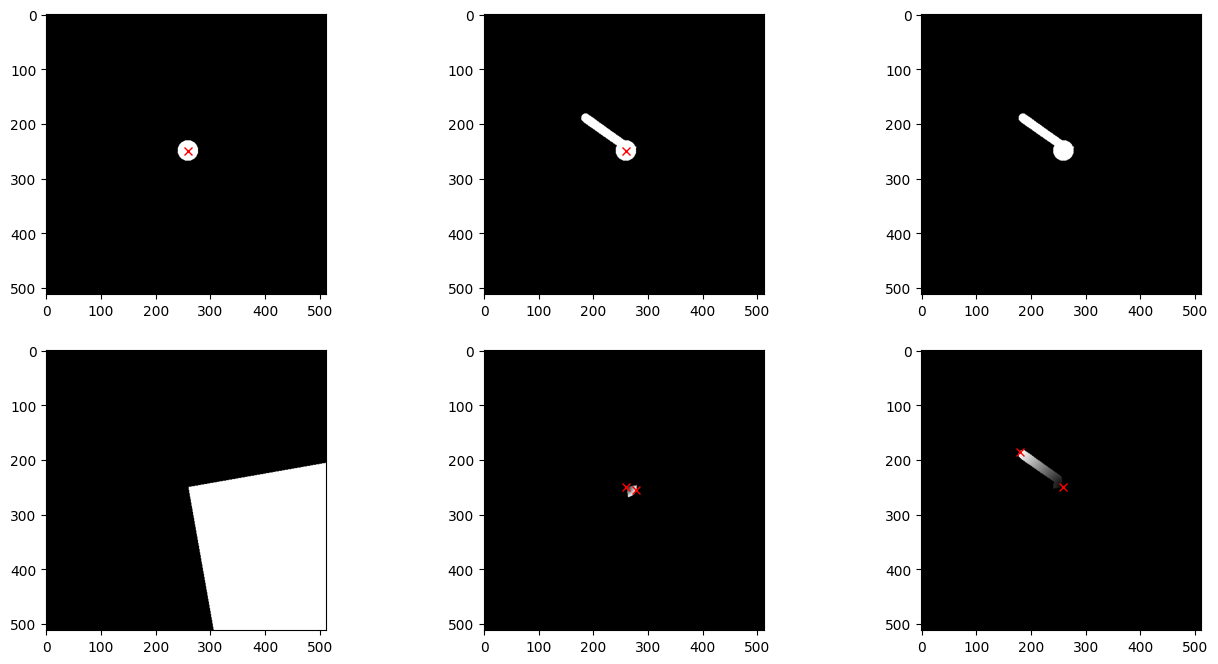

In [24]:
line = centers[2]
other_lines = [centers[1], centers[2]]
center = find_center(img, centers)
print(center)

dist_arr = dist_to_point_np(img, center)

fig, axs = plt.subplots(2, 3, figsize=(16, 8))

# 1 csak a vonal kornyezete + a kozeppont es vonal kozotti kor latszodjon
mask1 = in_range_of_line_np(img, line[0], line[1], 10)
dist1 = dist_to_line(center[0], center[1], line[0], line[1])
circ_mask = apply_circular_mask(img.shape, center, dist1)
mask1 = np.where(mask1, 255, 0).astype('uint8')
mask1 = cv2.bitwise_and(img, mask1)
mask1[circ_mask] = 255
axs[0,0].imshow(circ_mask, cmap='gray')
axs[0,0].plot(center[0], center[1], 'rx')
axs[0,1].imshow(mask1, cmap='gray')
axs[0,1].plot(center[0], center[1], 'rx')

# 2 floodfill esetlegesen bentmaradt szamok levagasara
h, w = img.shape[:2]
ff_mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(mask1, ff_mask, center, 255, 250, 255, cv2.FLOODFILL_FIXED_RANGE)
mask12 = np.where(ff_mask[1:-1, 1:-1] != 0, True, False)
axs[0,2].imshow(mask12, cmap='gray')

# 3 maskok a ket iranyra
azimuth2 = math.degrees(line[1])
mask2 = in_sector_np(img, center, ((azimuth2 - 45) % 360, (azimuth2 + 45) % 360))
print(azimuth2)
axs[1,0].imshow(mask2, cmap='gray')
mask2 &= mask12
azimuth3 = (azimuth2 + 180) % 360
mask3 = in_sector_np(img, center, ((azimuth3 - 45) % 360, (azimuth3 + 45) % 360))
mask3 &= mask12

# elso iranyba
dist_arr2 = dist_arr.copy()
dist_arr2[~mask2] = 0
dist2 = np.max(dist_arr2)
p2 = np.unravel_index(np.argmax(dist_arr2), dist_arr2.shape)
p2 = p2[::-1]
if dist2 == 0:
    p2 = center

# masodik iranyba
dist_arr3 = dist_arr.copy()
dist_arr3[~mask3] = 0
dist3 = np.max(dist_arr3)
p3 = np.unravel_index(np.argmax(dist_arr3), dist_arr3.shape)
p3 = p3[::-1]
if dist3 == 0:
    p3 = center

axs[1,1].imshow(dist_arr2, cmap='gray')
axs[1,1].plot(p2[0], p2[1], 'rx')
axs[1,1].plot(center[0], center[1], 'rx')
axs[1,2].imshow(dist_arr3, cmap='gray')
axs[1,2].plot(p3[0], p3[1], 'rx')
axs[1,2].plot(center[0], center[1], 'rx')

find_hand_widths(img, center, line, other_lines, end_dist, azi, azi_tol=20, r1=50, r2=110) függvény

4.508788936090241


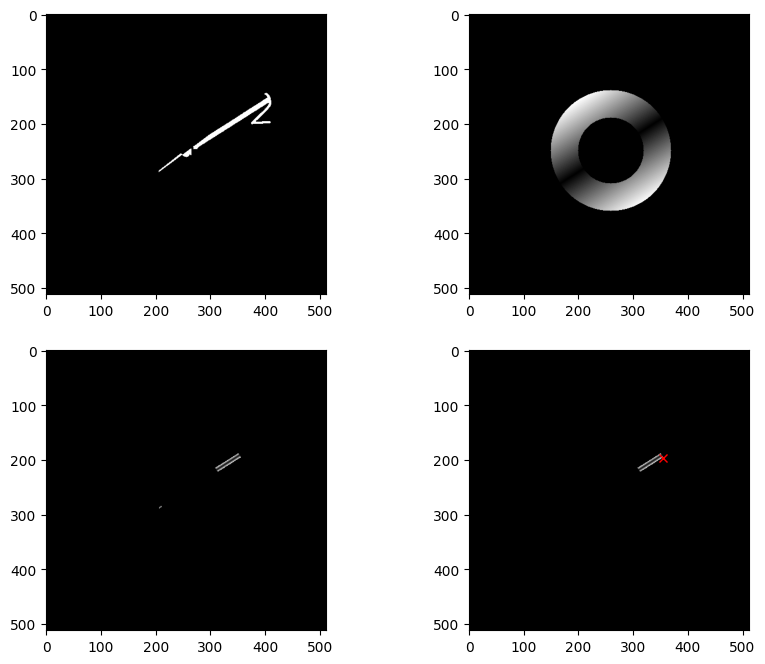

In [21]:
if dist2 > dist3:
    azi = azimuth2
    end_dist = dist2
else:
    azi = azimuth3
    end_dist = dist3

azi_tol=20
r1=60
r2=110

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

if end_dist < r2:
    r2 = end_dist

dist_arr = dist_to_line_np(img, line[0], line[1])

mask1 = apply_circular_mask(img.shape, center, r1)
mask2 = apply_circular_mask(img.shape, center, r2)
mask3 = closest_line_mask(img, line, other_lines) # a szegmentalt kep vonalhoz legkozelebbi resze
bool_img = img == 255
mask3 &= bool_img
axs[0,0].imshow(mask3, cmap='gray')
mask4 = in_sector_np(img, center, ((azi - azi_tol) % 360, (azi + azi_tol) % 360))

dist_arr[mask1] = 0
dist_arr[~mask2] = 0
axs[0,1].imshow(dist_arr, cmap='gray')
dist_arr[~mask3] = 0
axs[1,0].imshow(dist_arr, cmap='gray')
dist_arr[~mask4] = 0
axs[1,1].imshow(dist_arr, cmap='gray')

print(np.max(dist_arr))
p_max = np.unravel_index(np.argmax(dist_arr), dist_arr.shape)
p_max = p_max[::-1]
axs[1,1].plot(p_max[0], p_max[1], 'rx')

closest_line_mask függvény

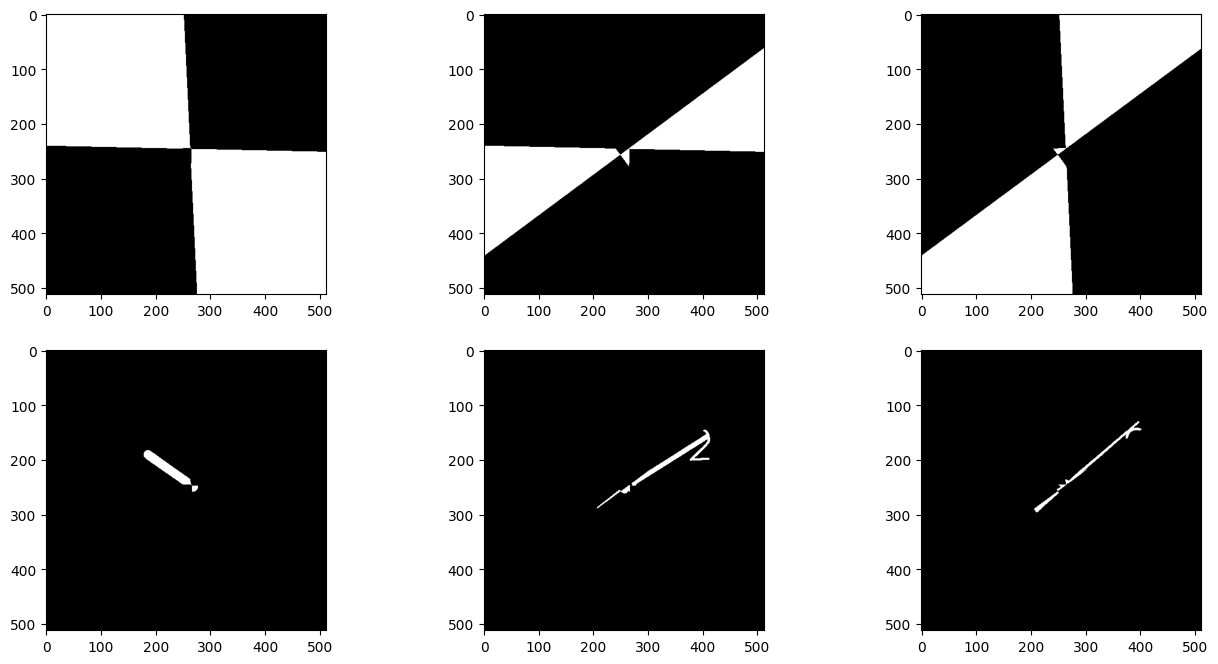

In [23]:
minute_line = centers[0]
second_line = centers[1]
hour_line = centers[2]

minute_mask = closest_line_mask(img, minute_line, [second_line, hour_line])
second_mask = closest_line_mask(img, second_line, [minute_line, hour_line])
hour_mask = closest_line_mask(img, hour_line, [minute_line, second_line])

im1 = img.copy()
im2 = img.copy()
im3 = img.copy()

im1[~hour_mask] = 0
im2[~minute_mask] = 0
im3[~second_mask] = 0

fig, axs = plt.subplots(2, 3, figsize=(16, 8))

axs[0,0].imshow(hour_mask, cmap='gray')
axs[0,1].imshow(minute_mask, cmap='gray')
axs[0,2].imshow(second_mask, cmap='gray')
axs[1,0].imshow(im1, cmap='gray')
axs[1,1].imshow(im2, cmap='gray')
axs[1,2].imshow(im3, cmap='gray')